In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, f1_score
from tqdm import tqdm

import gzip
import array
from io import FileIO
import struct
from urllib.request import urlretrieve
import pickle


In [2]:
resources = [
    'train-images-idx3-ubyte.gz',
    'train-labels-idx1-ubyte.gz',
    't10k-images-idx3-ubyte.gz',
    't10k-labels-idx1-ubyte.gz'
]

In [ ]:
BASE_URL = "https://ossci-datasets.s3.amazonaws.com/mnist/"

def download_mnist():
    for file in resources:
        urlretrieve(BASE_URL + file, file)
    
# download_mnist()

In [3]:
def parse_file(fd: FileIO):
    DATA_TYPES = {0x08: 'B', 0x09: 'b', 0x0b: 'h', 0x0c: 'i', 0x0d: 'f', 0x0e: 'd'}
    header = fd.read(4)
    _, data_type, num_dimensions = struct.unpack('>HBB', header)
    
    data_type = DATA_TYPES[data_type]
    dimension_sizes = struct.unpack('>' + 'I' * num_dimensions, fd.read(4 * num_dimensions))
    
    data = array.array(data_type, fd.read())
    data.byteswap()

    return np.array(data).reshape(dimension_sizes)

def load_file(fname):
    with gzip.open(fname, "rb") as fp:
        return parse_file(fp)

def mnist():
    return [load_file(fname) for fname in resources]

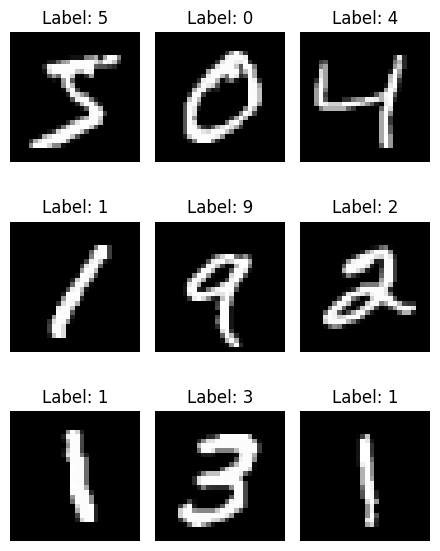

In [4]:
train_X, train_Y, test_X, test_Y = mnist()

fig, axes = plt.subplots(3, 3, figsize=(4.5, 6))
for i in range(9):
    ax = axes[i // 3, i % 3]
    ax.imshow(train_X[i], cmap='gray')
    ax.axis('off')
    ax.set_title(f'Label: {train_Y[i]}')
plt.tight_layout()
plt.show()

In [60]:
np.random.seed(42)

train_X = train_X.reshape((-1, 28*28)) / 255
test_X = test_X.reshape((-1, 28*28)) / 255

In [61]:
N_in = train_X.shape[1]
N_out = 10

N1 = 128
w1 = np.random.rand(N1, N_in) * 0.2 - 0.1
w2 = np.random.rand(N_out, N1) * 0.2 - 0.1
lmb = 0.01


def f(x):
    return 1/(1+np.exp(-x))

def df(x):
    return x*(1-x)

def ohe(label, classes):
    y = np.zeros(classes)
    y[label] = 1
    return y

N = 5
for i in tqdm(range(N)):
    for _ in range(train_X.shape[0]):
        idx = np.random.randint(train_X.shape[0])
        x_in, label = train_X[idx], train_Y[idx]

        A1 = x_in
        Z2 = w1 @ A1
        A2 = f(Z2)
        Z3 = w2 @ A2
        A3 = f(Z3)

        # Loss (Mean Squared Error)
        y_train = ohe(label, 10)
        loss = np.mean((A3 - y_train) ** 2)

        # Backward pass
        delta3 = A3 - y_train
        delta2 = delta3 @ w2 * df(A2)

        w1 -= lmb * np.expand_dims(delta2, axis=1) @ np.expand_dims(A1, axis=1).T#(delta2.T @ A1)
        w2 -= lmb * np.expand_dims(delta3, axis=1) @ np.expand_dims(A2, axis=1).T#(delta3.T @ A2)
    print(f"Loss: {loss}")


 20%|██        | 1/5 [00:12<00:50, 12.65s/it]

Loss: 0.0989171980750298


 40%|████      | 2/5 [00:25<00:38, 12.72s/it]

Loss: 0.10234672284898463


 60%|██████    | 3/5 [00:38<00:25, 12.79s/it]

Loss: 0.089109928636723


 80%|████████  | 4/5 [00:50<00:12, 12.68s/it]

Loss: 0.09315923442291515


100%|██████████| 5/5 [01:03<00:00, 12.75s/it]

Loss: 0.09664045883518577


0


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

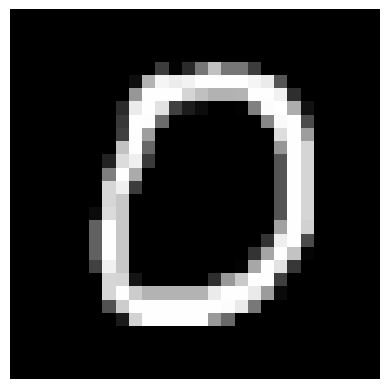

In [19]:
x, y_hat = test_X[10], test_Y[10]
y = f(w2 @ f(w1 @ x))
print(np.argmax(y))
plt.imshow(x.reshape((28, 28)), cmap='gray')
plt.axis('off')


In [95]:
import pickle

with open("weights.bin", "wb") as fp:
    pickle.dump((w1, w2), fp)

In [9]:
import pickle

with open("weights.bin", "rb") as fp:
    w1, w2 = pickle.load(fp)

In [58]:
def g(a, b, c):
    return (a + b + c + abs(a - b) + abs(b - c) + abs(c - a)) // 3
    #(a + b + c - abs(a - b) - abs(b - c) - abs(c - a)) // 3

print(g(1, 1, 2))
print(g(2, 2, 1))

2
2
